# GPN-MSA Testing with Datasets

## Setup environment 

In [ ]:
# only need once for GPN-MSA use
# !pip install git+https://github.com/songlab-cal/gpn.git

In [ ]:
# !ldconfig /usr/lib64-nvidia

In [1]:
from gpn.data import GenomeMSA, Tokenizer
import gpn.model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
from transformers import AutoModel, AutoModelForMaskedLM

/cm/shared/apps/spack/0.17.3/cpu/b/opt/spack/linux-rocky8-zen/gcc-8.5.0/anaconda3-2021.05-q4munrgvh7qp4o7r3nzcdkbuph4z7375/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
from datasets import load_dataset, disable_caching
from gpn.data import load_dataset_from_file_or_dir

In [3]:
dataset_prefix = "/expanse/lustre/projects/nji102/sgriesmer/gpn/Datasets/"

In [4]:
input_file =  dataset_prefix + "test.parquet"
dataset = load_dataset_from_file_or_dir(input_file, split="test", is_file=True)

## Create datasets

### Create Pathogenic dataset (only needed once)

In [5]:
dataset_pathogenic = dataset.filter(lambda v: v["source"]=="ClinVar" or (v["label"]=="Common" and "missense" in v["consequence"]))
dataset_pathogenic.shape

Filter:   0%|          | 0/9761267 [00:00<?, ? examples/s]

(39652, 21)

### Create Cancer dataset (only needed once)

In [ ]:
dataset_cancer = dataset.filter(lambda v: v["source"]=="COSMIC" or (v["label"]=="Common" and "missense" in v["consequence"]))
dataset_cancer.shape

### Create Regulatory dataset (only needed once)

In [ ]:
cs = ["5_prime_UTR", "upstream_gene", "intergenic", "3_prime_UTR", "non_coding_transcript_exon"]
dataset_regulatory = dataset.filter(lambda v: v["source"]=="OMIM" or (v["label"]=="Common" and "missense" not in v["consequence"] and any([c in v["consequence"] for c in cs])))
dataset_regulatory.shape

## Save datasets as parquet files

In [ ]:
dataset_pathogenic_filename = dataset_prefix + "pathogenic.parquet"
dataset_pathogenic.to_parquet(dataset_pathogenic_filename)

In [ ]:
dataset_cancer_filename = dataset_prefix + "cancer.parquet"
dataset_cancer.to_parquet(dataset_cancer_filename)

In [ ]:
dataset_regulatory_filename = dataset_prefix + "regulatory.parquet"
dataset_regulatory.to_parquet(dataset_regulatory_filename)

# Test and Score with GPN-MSA

## Load Dataset to be Scored (if previously created)

In [6]:
dataset_pathogenic_filename = dataset_prefix + "pathogenic.parquet"
dataset_pathogenic = load_dataset_from_file_or_dir(dataset_pathogenic_filename, split="test", is_file=True)
dataset_pathogenic.shape

(39652, 21)

## Load MSA data

In [7]:
msa_path = "zip:///::https://huggingface.co/datasets/songlab/multiz100way/resolve/main/89.zarr.zip"
genome_msa = GenomeMSA(msa_path)  # can take a minute or two

Loading MSA...
Loading MSA... Done


## Load inference model

In [8]:
from gpn.msa.vep import VEPInference

model_path = "songlab/gpn-msa-sapiens"
window_size = 128
vep_inf = VEPInference(model_path, genome_msa, window_size, disable_aux_features=False)

## Pathogenic Dataset

## Subset Dataset to be Scored

In [9]:
set_start = 30000
set_end = 39652
dataset_pathogenic_set = dataset_pathogenic.select(range(set_start, set_end))
df_pathogenic_set = pd.DataFrame(dataset_pathogenic_set)
df_pathogenic_set

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,total_samples,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC
0,17,31338139,G,C,Pathogenic,ClinVar,missense_variant,933505,"criteria_provided,_single_submitter",None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
1,17,31340596,T,C,Pathogenic,ClinVar,missense_variant,1070418,"criteria_provided,_single_submitter",None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
2,17,31349177,T,C,Pathogenic,ClinVar,missense_variant,1075890,"criteria_provided,_single_submitter",None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
3,17,31349249,C,T,Pathogenic,ClinVar,missense_variant,2121325,"criteria_provided,_single_submitter",None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
4,17,31488367,G,T,Common,gnomAD,"5_prime_UTR_variant,intron_variant,intron_vari...",None,None,None,...,None,None,None,None,None,55889.0,151506.0,0.36889,0.36889,55889.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9647,Y,2787412,C,T,Pathogenic,ClinVar,missense_variant,9747,no_assertion_criteria_provided,None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
9648,Y,2787426,C,G,Pathogenic,ClinVar,missense_variant,9739,"criteria_provided,_single_submitter",None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
9649,Y,2787515,C,A,Pathogenic,ClinVar,missense_variant,492908,no_assertion_criteria_provided,None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
9650,Y,2787551,C,T,Pathogenic,ClinVar,missense_variant,9754,no_assertion_criteria_provided,None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN


## Tokenize Dataset

In [10]:
dataset_pathogenic_set.set_transform(vep_inf.tokenize_function)

## Set Arguments for Testing

In [11]:
from transformers import Trainer, TrainingArguments

output_dir = "/expanse/lustre/projects/nji102/sgriesmer/gpn/output"

batch_size = 100
training_args = TrainingArguments(
  output_dir=output_dir,
  per_device_eval_batch_size=batch_size,
  dataloader_num_workers=0,
  remove_unused_columns=False,
#  torch_compile=True,
#  fp16=True,
)

In [12]:
trainer = Trainer(
    model=vep_inf.model,
    args=training_args
)

## Test and Score Dataset Subset

In [13]:
# for debugging purposes
!TORCH_LOGS="+dynamo"
!TORCHDYNAMO_VERBOSE=1

In [14]:
pred=trainer.predict(test_dataset=dataset_pathogenic_set).predictions

## Add Score to Dataframe

In [15]:
gpn_score = vep_inf.postprocess(pred)
df_pathogenic_set["gpn_score"] = gpn_score
df_pathogenic_set.head()

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC,gpn_score
0,17,31338139,G,C,Pathogenic,ClinVar,missense_variant,933505,"criteria_provided,_single_submitter",None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-12.350409
1,17,31340596,T,C,Pathogenic,ClinVar,missense_variant,1070418,"criteria_provided,_single_submitter",None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-12.276096
2,17,31349177,T,C,Pathogenic,ClinVar,missense_variant,1075890,"criteria_provided,_single_submitter",None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-11.199671
3,17,31349249,C,T,Pathogenic,ClinVar,missense_variant,2121325,"criteria_provided,_single_submitter",None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-10.639453
4,17,31488367,G,T,Common,gnomAD,"5_prime_UTR_variant,intron_variant,intron_vari...",None,None,None,...,None,None,None,None,55889.0,151506.0,0.36889,0.36889,55889.0,-1.922046


## Plot shows differentiation between Common and Pathogenic mutations

<AxesSubplot:xlabel='gpn_score', ylabel='Count'>

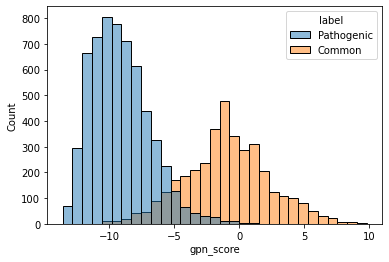

In [16]:
sns.histplot(data=df_pathogenic_set, x="gpn_score", hue="label")

## Save dataframe as CSV

In [ ]:
output_file = output_dir + "/pathogenic_set" + "_" + str(set_start) + "_" + str(set_end) + ".csv"
df_pathogenic_set.to_csv(output_file, index=False, sep=',')

## Load dataframe from CSV (if needed)

In [8]:
output_dir = "/expanse/lustre/projects/nji102/sgriesmer/gpn/output"

input_csv_file = output_dir + "/pathogenic_set_0_39652.csv"
df_pathogenic_set = pd.read_csv(input_csv_file, sep=',')

<ipython-input-8-745ab015dd90>:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pathogenic_set = pd.read_csv(input_csv_file, sep=',')


<AxesSubplot:xlabel='gpn_score', ylabel='Count'>

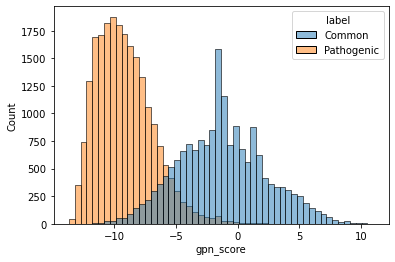

In [15]:
sns.histplot(data=df_pathogenic_set, x="gpn_score", hue="label")

## Calculate metrics

In [11]:
from sklearn.metrics import roc_auc_score, average_precision_score
AUROC = roc_auc_score(df_pathogenic_set.label=="Pathogenic", -df_pathogenic_set.gpn_score)
AUPRC = average_precision_score(df_pathogenic_set.label=="Pathogenic", -df_pathogenic_set.gpn_score)
AUROC, AUPRC

(0.9700963898783034, 0.9754532666779846)

## Plot ROC curve

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df_pathogenic_set.label=="Pathogenic", -df_pathogenic_set.gpn_score)

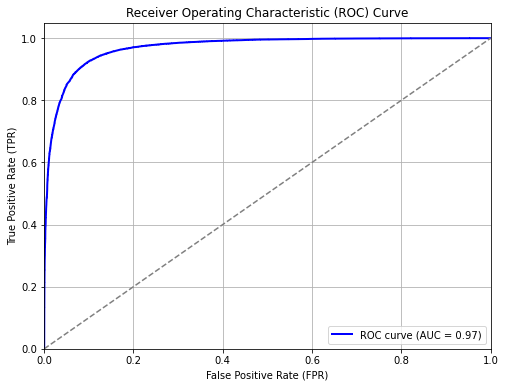

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {AUROC:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Cancer Dataset

## Load Dataset to be Scored (if previously created)

In [6]:
dataset_cancer_filename = dataset_prefix + "cancer.parquet"
dataset_cancer = load_dataset_from_file_or_dir(dataset_cancer_filename, split="test", is_file=True)
dataset_cancer.shape

(17587, 21)

## Load MSA data

In [7]:
msa_path = "zip:///::https://huggingface.co/datasets/songlab/multiz100way/resolve/main/89.zarr.zip"
genome_msa = GenomeMSA(msa_path)  # can take a minute or two

Loading MSA...
Loading MSA... Done


## Load inference model

In [8]:
from gpn.msa.vep import VEPInference

model_path = "songlab/gpn-msa-sapiens"
window_size = 128
vep_inf = VEPInference(model_path, genome_msa, window_size, disable_aux_features=False)

## Subset Dataset to be Scored

In [9]:
set_start = 0
set_end = 17587
dataset_cancer_set = dataset_cancer.select(range(set_start, set_end))
df_cancer_set = pd.DataFrame(dataset_cancer_set)
df_cancer_set

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,total_samples,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC
0,1,924305,G,A,Common,gnomAD,"5_prime_UTR_variant,missense_variant,regulator...",None,None,None,...,NaN,NaN,None,None,None,25773.0,149442.0,0.172462,0.172462,25773.0
1,1,924310,C,G,Common,gnomAD,"5_prime_UTR_variant,missense_variant,regulator...",None,None,None,...,NaN,NaN,None,None,None,118962.0,149302.0,0.796788,0.203212,30340.0
2,1,924533,A,G,Common,gnomAD,"missense_variant,regulatory_region_variant,syn...",None,None,None,...,NaN,NaN,None,None,None,122704.0,149364.0,0.821510,0.178490,26660.0
3,1,953279,T,C,Common,gnomAD,"downstream_gene_variant,missense_variant,non_c...",None,None,None,...,NaN,NaN,None,None,None,142160.0,152178.0,0.934169,0.065831,10018.0
4,1,962350,C,T,Common,gnomAD,"5_prime_UTR_variant,missense_variant,non_codin...",None,None,None,...,NaN,NaN,None,None,None,10502.0,152116.0,0.069039,0.069039,10502.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17582,22,50626933,C,A,Common,gnomAD,"missense_variant,non_coding_transcript_exon_va...",None,None,None,...,NaN,NaN,None,None,None,7779.0,152216.0,0.051105,0.051105,7779.0
17583,22,50679152,T,C,Common,gnomAD,"downstream_gene_variant,missense_variant,misse...",None,None,None,...,NaN,NaN,None,None,None,69803.0,151812.0,0.459799,0.459799,69803.0
17584,22,50744827,A,G,Common,gnomAD,"downstream_gene_variant,missense_variant,non_c...",None,None,None,...,NaN,NaN,None,None,None,100960.0,148446.0,0.680113,0.319887,47486.0
17585,X,40062191,T,C,Frequent,COSMIC,missense_variant,None,None,COSV60698733,...,43169.0,0.001158,None,None,None,NaN,NaN,NaN,NaN,NaN


## Tokenize Dataset

In [10]:
dataset_cancer_set.set_transform(vep_inf.tokenize_function)

## Set Arguments for Testing

In [11]:
from transformers import Trainer, TrainingArguments

output_dir = "/expanse/lustre/projects/nji102/sgriesmer/gpn/output"

batch_size = 100
training_args = TrainingArguments(
  output_dir=output_dir,
  per_device_eval_batch_size=batch_size,
  dataloader_num_workers=0,
  remove_unused_columns=False,
#  torch_compile=True,
#  fp16=True,
)

In [12]:
trainer = Trainer(
    model=vep_inf.model,
    args=training_args
)

## Test and Score Dataset Subset

In [13]:
# for debugging purposes
!TORCH_LOGS="+dynamo"
!TORCHDYNAMO_VERBOSE=1

In [14]:
pred=trainer.predict(test_dataset=dataset_cancer_set).predictions

## Add Score to Dataframe

In [33]:
gpn_score = vep_inf.postprocess(pred)
df_cancer_set["gpn_score"] = gpn_score
df_cancer_set.head()

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC,gpn_score
0,1,924305,G,A,Common,gnomAD,"5_prime_UTR_variant,missense_variant,regulator...",None,None,None,...,NaN,None,None,None,25773.0,149442.0,0.172462,0.172462,25773.0,-3.533378
1,1,924310,C,G,Common,gnomAD,"5_prime_UTR_variant,missense_variant,regulator...",None,None,None,...,NaN,None,None,None,118962.0,149302.0,0.796788,0.203212,30340.0,6.221670
2,1,924533,A,G,Common,gnomAD,"missense_variant,regulatory_region_variant,syn...",None,None,None,...,NaN,None,None,None,122704.0,149364.0,0.821510,0.178490,26660.0,0.623985
3,1,953279,T,C,Common,gnomAD,"downstream_gene_variant,missense_variant,non_c...",None,None,None,...,NaN,None,None,None,142160.0,152178.0,0.934169,0.065831,10018.0,2.577397
4,1,962350,C,T,Common,gnomAD,"5_prime_UTR_variant,missense_variant,non_codin...",None,None,None,...,NaN,None,None,None,10502.0,152116.0,0.069039,0.069039,10502.0,-5.128582


## Plot shows differentiation between Common and COSMIC/Frequent mutations

<AxesSubplot:xlabel='gpn_score', ylabel='Count'>

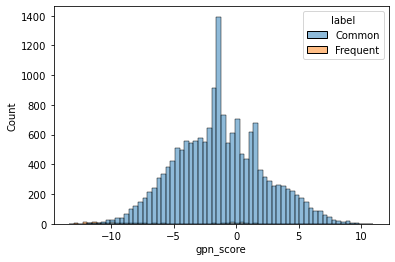

In [18]:
sns.histplot(data=df_cancer_set, x="gpn_score", hue="label")

## Save dataframe as CSV

In [19]:
output_file = output_dir + "/cancer_set" + "_" + str(set_start) + "_" + str(set_end) + ".csv"
df_cancer_set.to_csv(output_file, index=False, sep=',')

## Calculate metrics

In [28]:
df_cancer_set[17585:17587]

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC,gpn_score
17585,X,40062191,T,C,Frequent,COSMIC,missense_variant,None,None,COSV60698733,...,0.001158,None,None,None,NaN,NaN,NaN,NaN,NaN,-8.914214
17586,X,67545319,A,T,Frequent,COSMIC,missense_variant,None,None,COSV65953279,...,0.001205,None,None,None,NaN,NaN,NaN,NaN,NaN,-5.283038


In [29]:
from sklearn.metrics import roc_auc_score, average_precision_score
AUROC = roc_auc_score(df_cancer_set.label=="Frequent", -gpn_score)
AUPRC = average_precision_score(df_cancer_set.label=="Frequent", -gpn_score)
AUROC, AUPRC

(0.7684140547688081, 0.34090608703468356)

## Plot ROC curve

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df_cancer_set.label=="Frequent", -gpn_score)

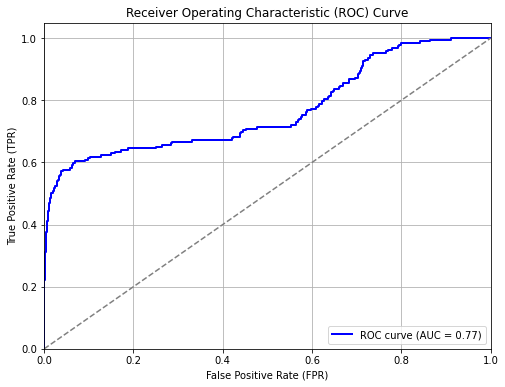

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {AUROC:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
## Regulatory Dataset

## Load Dataset to be Scored (if previously created)

In [4]:
dataset_regulatory_filename = dataset_prefix + "regulatory.parquet"
dataset_regulatory = load_dataset_from_file_or_dir(dataset_regulatory_filename, split="test", is_file=True)
dataset_regulatory.shape

(2321473, 21)

## Load MSA data

In [5]:
msa_path = "zip:///::https://huggingface.co/datasets/songlab/multiz100way/resolve/main/89.zarr.zip"
genome_msa = GenomeMSA(msa_path)  # can take a minute or two

Loading MSA...
Loading MSA... Done


## Load inference model

In [6]:
from gpn.msa.vep import VEPInference

model_path = "songlab/gpn-msa-sapiens"
window_size = 128
vep_inf = VEPInference(model_path, genome_msa, window_size, disable_aux_features=False)

## Subset Dataset to be Scored

In [7]:
set_start = 600000
set_end = 800000
dataset_regulatory_set = dataset_regulatory.select(range(set_start, set_end))
df_regulatory_set = pd.DataFrame(dataset_regulatory_set)
df_regulatory_set

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,total_samples,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC
0,4,91214120,G,C,Common,gnomAD,"3_prime_UTR_variant,intron_variant",None,None,None,...,None,None,None,None,NaN,94196.0,151762.0,0.620682,0.379318,57566.0
1,4,91214376,A,T,Common,gnomAD,"3_prime_UTR_variant,intron_variant",None,None,None,...,None,None,None,None,NaN,8160.0,152110.0,0.053645,0.053645,8160.0
2,4,91215394,T,C,Common,gnomAD,"3_prime_UTR_variant,intron_variant",None,None,None,...,None,None,None,None,NaN,62633.0,151808.0,0.412580,0.412580,62633.0
3,4,91308841,G,A,Common,gnomAD,"3_prime_UTR_variant,intron_variant",None,None,None,...,None,None,None,None,NaN,118656.0,151724.0,0.782052,0.217948,33068.0
4,4,91308949,G,C,Common,gnomAD,"3_prime_UTR_variant,intron_variant",None,None,None,...,None,None,None,None,NaN,117958.0,151662.0,0.777769,0.222231,33704.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,5,127544833,C,T,Common,gnomAD,"intron_variant,upstream_gene_variant",None,None,None,...,None,None,None,None,NaN,45743.0,151976.0,0.300988,0.300988,45743.0
199996,5,127546088,C,T,Common,gnomAD,"intron_variant,upstream_gene_variant",None,None,None,...,None,None,None,None,NaN,8185.0,152082.0,0.053820,0.053820,8185.0
199997,5,127547328,A,T,Common,gnomAD,"intron_variant,upstream_gene_variant",None,None,None,...,None,None,None,None,NaN,18565.0,151980.0,0.122154,0.122154,18565.0
199998,5,127548526,C,G,Common,gnomAD,"3_prime_UTR_variant,intron_variant,intron_vari...",None,None,None,...,None,None,None,None,NaN,10021.0,147274.0,0.068043,0.068043,10021.0


## Tokenize Dataset

In [8]:
dataset_regulatory_set.set_transform(vep_inf.tokenize_function)

## Set Arguments for Testing

In [9]:
from transformers import Trainer, TrainingArguments

output_dir = "/expanse/lustre/projects/nji102/sgriesmer/gpn/output"

batch_size = 500
training_args = TrainingArguments(
  output_dir=output_dir,
  per_device_eval_batch_size=batch_size,
  dataloader_num_workers=0,
  remove_unused_columns=False,
#  torch_compile=True,
#  fp16=True,
)

In [10]:
trainer = Trainer(
    model=vep_inf.model,
    args=training_args
)

## Test and Score Dataset Subset

In [11]:
# for debugging purposes
!TORCH_LOGS="+dynamo"
!TORCHDYNAMO_VERBOSE=1

In [12]:
pred=trainer.predict(test_dataset=dataset_regulatory_set).predictions

## Add Score to Dataframe

In [13]:
gpn_score = vep_inf.postprocess(pred)
df_regulatory_set["gpn_score"] = gpn_score
df_regulatory_set.head()

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC,gpn_score
0,4,91214120,G,C,Common,gnomAD,"3_prime_UTR_variant,intron_variant",None,None,None,...,None,None,None,NaN,94196.0,151762.0,0.620682,0.379318,57566.0,-1.473635
1,4,91214376,A,T,Common,gnomAD,"3_prime_UTR_variant,intron_variant",None,None,None,...,None,None,None,NaN,8160.0,152110.0,0.053645,0.053645,8160.0,-1.444305
2,4,91215394,T,C,Common,gnomAD,"3_prime_UTR_variant,intron_variant",None,None,None,...,None,None,None,NaN,62633.0,151808.0,0.412580,0.412580,62633.0,-0.383988
3,4,91308841,G,A,Common,gnomAD,"3_prime_UTR_variant,intron_variant",None,None,None,...,None,None,None,NaN,118656.0,151724.0,0.782052,0.217948,33068.0,1.487234
4,4,91308949,G,C,Common,gnomAD,"3_prime_UTR_variant,intron_variant",None,None,None,...,None,None,None,NaN,117958.0,151662.0,0.777769,0.222231,33704.0,-1.355426


## Plot shows differentiation between Common and OMIM/Pathogenic mutations

<AxesSubplot:xlabel='gpn_score', ylabel='Count'>

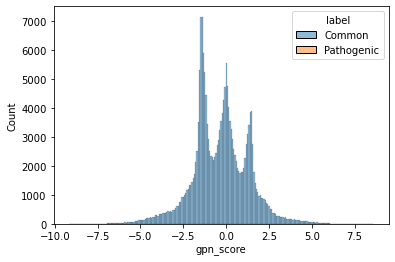

In [14]:
sns.histplot(data=df_regulatory_set, x="gpn_score", hue="label")

## Save dataframe as CSV

In [15]:
output_file = output_dir + "/regulatory_set" + "_" + str(set_start) + "_" + str(set_end) + ".csv"
df_regulatory_set.to_csv(output_file, index=False, sep=',')

In [ ]:
## Load dataframe from CSV (if needed)

In [30]:
output_dir = "/expanse/lustre/projects/nji102/sgriesmer/gpn/output"

input_csv_file = [output_dir + "/regulatory_set_0_100000.csv", 
output_dir + "/regulatory_set_100000_200000.csv",
output_dir + "/regulatory_set_200000_300000.csv",
output_dir + "/regulatory_set_300000_400000.csv",
output_dir + "/regulatory_set_400000_600000.csv",
output_dir + "/regulatory_set_600000_800000.csv"]

df_regulatory_subset = []
for f in input_csv_file:
    df_regulatory_subset.append(pd.read_csv(f, sep=','))
    
df_regulatory_set = pd.concat(df_regulatory_subset, axis=0)

<ipython-input-30-413c7aedd956>:12: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_regulatory_subset.append(pd.read_csv(f, sep=','))
<ipython-input-30-413c7aedd956>:12: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_regulatory_subset.append(pd.read_csv(f, sep=','))
<ipython-input-30-413c7aedd956>:12: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_regulatory_subset.append(pd.read_csv(f, sep=','))
<ipython-input-30-413c7aedd956>:12: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_regulatory_subset.append(pd.read_csv(f, sep=','))
<ipython-input-30-413c7aedd956>:12: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_regulatory_subset.append(pd.read_csv(f, sep=','))


In [31]:
df_regulatory_set

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC,gpn_score
0,1,126113,C,A,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,135835.0,144502.0,0.940022,0.059978,8667.0,1.975200
1,1,129315,A,G,Common,gnomAD,"intron_variant&non_coding_transcript_variant,u...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15364.0,144124.0,0.106603,0.106603,15364.0,-1.577225
2,1,133160,G,A,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13758.0,148950.0,0.092367,0.092367,13758.0,-0.618113
3,1,133483,G,T,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,44261.0,143434.0,0.308581,0.308581,44261.0,-1.408843
4,1,135040,T,C,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13459.0,148318.0,0.090744,0.090744,13459.0,-1.914278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,5,127544833,C,T,Common,gnomAD,"intron_variant,upstream_gene_variant",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,45743.0,151976.0,0.300988,0.300988,45743.0,1.129158
199996,5,127546088,C,T,Common,gnomAD,"intron_variant,upstream_gene_variant",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8185.0,152082.0,0.053820,0.053820,8185.0,0.136231
199997,5,127547328,A,T,Common,gnomAD,"intron_variant,upstream_gene_variant",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18565.0,151980.0,0.122154,0.122154,18565.0,-1.580191
199998,5,127548526,C,G,Common,gnomAD,"3_prime_UTR_variant,intron_variant,intron_vari...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10021.0,147274.0,0.068043,0.068043,10021.0,-1.683461


<AxesSubplot:xlabel='gpn_score', ylabel='Count'>

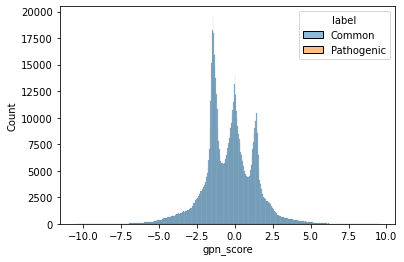

In [29]:
sns.histplot(data=df_regulatory_set, x="gpn_score", hue="label")

## Calculate metrics

In [24]:
df_regulatory_set

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC,gpn_score
0,1,126113,C,A,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,135835.0,144502.0,0.940022,0.059978,8667.0,1.975200
1,1,129315,A,G,Common,gnomAD,"intron_variant&non_coding_transcript_variant,u...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15364.0,144124.0,0.106603,0.106603,15364.0,-1.577225
2,1,133160,G,A,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13758.0,148950.0,0.092367,0.092367,13758.0,-0.618113
3,1,133483,G,T,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,44261.0,143434.0,0.308581,0.308581,44261.0,-1.408843
4,1,135040,T,C,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13459.0,148318.0,0.090744,0.090744,13459.0,-1.914278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,5,127544833,C,T,Common,gnomAD,"intron_variant,upstream_gene_variant",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,45743.0,151976.0,0.300988,0.300988,45743.0,1.129158
199996,5,127546088,C,T,Common,gnomAD,"intron_variant,upstream_gene_variant",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8185.0,152082.0,0.053820,0.053820,8185.0,0.136231
199997,5,127547328,A,T,Common,gnomAD,"intron_variant,upstream_gene_variant",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18565.0,151980.0,0.122154,0.122154,18565.0,-1.580191
199998,5,127548526,C,G,Common,gnomAD,"3_prime_UTR_variant,intron_variant,intron_vari...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10021.0,147274.0,0.068043,0.068043,10021.0,-1.683461


In [26]:
from sklearn.metrics import roc_auc_score, average_precision_score
AUROC = roc_auc_score(df_regulatory_set.label=="Pathogenic", -df_regulatory_set.gpn_score)
AUPRC = average_precision_score(df_regulatory_set.label=="Pathogenic", -df_regulatory_set.gpn_score)
AUROC, AUPRC

(0.9052443039344307, 0.08654054034831823)

## Plot ROC curve

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df_regulatory_set.label=="Pathogenic", -df_regulatory_set.gpn_score)

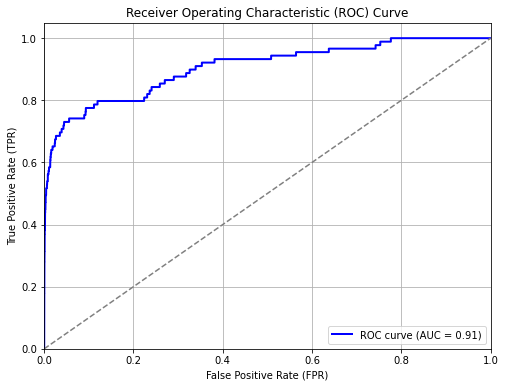

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {AUROC:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()